# Extracting Long-Term Memory from a Conversation
This Notebook shows how to set up an agent that can extract memories from a conversation.

### Notebook Setup

In [1]:
# %pip install openai==1.12.0 langchain==0.1.6 langchain_openai==0.0.5

In [2]:
from dotenv import load_dotenv
import os

# Load .env file
load_dotenv()

# Set model variables
OPENAI_BASE_URL = "https://api.openai.com/v1"
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_ORGANIZATION = os.getenv("OPENAI_ORGANIZATION")

# Initialize LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "Demos"

### Set up Agent: Memory Sentinel

In [3]:
from langchain_openai.chat_models import ChatOpenAI
from langchain.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    MessagesPlaceholder,
)
from langchain_core.runnables import RunnablePassthrough


system_prompt_initial = """
Your job is to assess a brief chat history in order to determine if the conversation contains any details about a family's dining habits. 

You are part of a team building a knowledge base regarding a family's dining habits to assist in highly customized meal planning.

You play the critical role of assessing the message to determine if it contains any information worth recording in the knowledge base.

You are only interested in the following categories of information:

1. The family's food allergies (e.g. a dairy or soy allergy)
2. Foods the family likes (e.g. likes pasta)
3. Foods the family dislikes (e.g. doesn't eat mussels)
4. Attributes about the family that may impact weekly meal planning (e.g. lives in Austin; has a husband and 2 children; has a garden; likes big lunches; etc.)

When you receive a message, you perform a sequence of steps consisting of:

1. Analyze the message for information.
2. If it has any information worth recording, return TRUE. If not, return FALSE.

You should ONLY RESPOND WITH TRUE OR FALSE. Absolutely no other information should be provided.

Take a deep breath, think step by step, and then analyze the following message:
"""

# Get the prompt to use - you can modify this!
prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessagePromptTemplate.from_template(system_prompt_initial),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Remember, only respond with TRUE or FALSE. Do not provide any other information.",
        ),
    ]
)

# Choose the LLM that will drive the agent
llm = ChatOpenAI(
    model="gpt-3.5-turbo-0125",
    streaming=True,
    temperature=0.0,
)

sentinel_runnable = {"messages": RunnablePassthrough()} | prompt | llm

### Set up Agent: Memory Manager

In [4]:
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import StructuredTool
from enum import Enum
from typing import Optional


class Category(str, Enum):
    Food_Allergy = "Allergy"
    Food_Like = "Like"
    Food_Dislike = "Dislike"
    Family_Attribute = "Attribute"


class Action(str, Enum):
    Create = "Create"
    Update = "Update"
    Delete = "Delete"


class AddKnowledge(BaseModel):
    knowledge: str = Field(
        ...,
        description="Condensed bit of knowledge to be saved for future reference in the format: [person(s) this is relevant to] [fact to store] (e.g. Husband doesn't like tuna; I am allergic to shellfish; etc)",
    )
    knowledge_old: Optional[str] = Field(
        None,
        description="If updating or deleting record, the complete, exact phrase that needs to be modified",
    )
    category: Category = Field(
        ..., description="Category that this knowledge belongs to"
    )
    action: Action = Field(
        ...,
        description="Whether this knowledge is adding a new record, updating a record, or deleting a record",
    )


def modify_knowledge(
    knowledge: str,
    category: str,
    action: str,
    knowledge_old: str = "",
) -> dict:
    print("Modifying Knowledge: ", knowledge, knowledge_old, category, action)
    return "Modified Knowledge"


tool_modify_knowledge = StructuredTool.from_function(
    func=modify_knowledge,
    name="Knowledge_Modifier",
    description="Add, update, or delete a bit of knowledge",
    args_schema=AddKnowledge,
)

In [5]:
# Set up the tools to execute them from the graph
from langgraph.prebuilt import ToolExecutor

# Set up the agent's tools
agent_tools = [tool_modify_knowledge]

tool_executor = ToolExecutor(agent_tools)

In [6]:
from langchain_openai.chat_models import ChatOpenAI
from langchain.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    MessagesPlaceholder,
)
from langchain_core.utils.function_calling import convert_to_openai_function

system_prompt_initial = """
You are a supervisor managing a team of knowledge eperts.

Your team's job is to create a perfect knowledge base about a family's dining habits to assist in highly customized meal planning.

The knowledge base should ultimately consist of many discrete pieces of information that add up to a rich persona (e.g. I like pasta; I am allergic to shellfish; I don't eat mussels; I live in Austin, Texas; I have a husband and 2 children aged 5 and 7).

Every time you receive a message, you will evaluate if it has any information worth recording in the knowledge base.

A message may contain multiple pieces of information that should be saved separately.

You are only interested in the following categories of information:

1. The family's food allergies (e.g. a dairy or soy allergy) - These are important to know because they can be life-threatening. Only log something as an allergy if you are certain it is an allergy and not just a dislike.
2. Foods the family likes (e.g. likes pasta) - These are important to know because they can help you plan meals, but are not life-threatening.
3. Foods the family dislikes (e.g. doesn't eat mussels or rarely eats beef) - These are important to know because they can help you plan meals, but are not life-threatening.
4. Attributes about the family that may impact weekly meal planning (e.g. lives in Austin; has a husband and 2 children; has a garden; likes big lunches, etc.)

When you receive a message, you perform a sequence of steps consisting of:

1. Analyze the most recent Human message for information. You will see multiple messages for context, but we are only looking for new information in the most recent message.
2. Compare this to the knowledge you already have.
3. Determine if this is new knowledge, an update to old knowledge that now needs to change, or should result in deleting information that is not correct. It's possible that a food you previously wrote as a dislike might now be a like, or that a family member who previously liked a food now dislikes it - those examples would require an update.

Here are the existing bits of information that we have about the family.

```
{memories}
```

Call the right tools to save the information, then respond with DONE. If you identiy multiple pieces of information, call everything at once. You only have one chance to call tools.

I will tip you $20 if you are perfect, and I will fine you $40 if you miss any important information or change any incorrect information.

Take a deep breath, think step by step, and then analyze the following message:
"""

# Get the prompt to use - you can modify this!
prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessagePromptTemplate.from_template(system_prompt_initial),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# Choose the LLM that will drive the agent
llm = ChatOpenAI(
    # model="gpt-3.5-turbo-0125",
    model="gpt-4-0125-preview",
    streaming=True,
    temperature=0.0,
)

# Create the tools to bind to the model
tools = [convert_to_openai_function(t) for t in agent_tools]

knowledge_master_runnable = prompt | llm.bind_tools(tools)

### Set up the Graph

In [7]:
from typing import TypedDict, Sequence
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    # The list of previous messages in the conversation
    messages: Sequence[BaseMessage]
    # The long-term memories to remember
    memories: Sequence[str]
    # Whether the information is relevant
    contains_information: str

In [8]:
import json
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolInvocation


def call_sentinel(state):
    messages = state["messages"]
    response = sentinel_runnable.invoke(messages)
    return {"contains_information": "TRUE" in response.content and "yes" or "no"}


# Define the function that determines whether to continue or not
def should_continue(state):
    last_message = state["messages"][-1]
    # If there are no tool calls, then we finish
    if "tool_calls" not in last_message.additional_kwargs:
        return "end"
    # Otherwise, we continue
    else:
        return "continue"


# Define the function that calls the knowledge master
def call_knowledge_master(state):
    messages = state["messages"]
    memories = state["memories"]
    response = knowledge_master_runnable.invoke(
        {"messages": messages, "memories": memories}
    )
    return {"messages": messages + [response]}


# Define the function to execute tools
def call_tool(state):
    messages = state["messages"]
    # We know the last message involves at least one tool call
    last_message = messages[-1]

    # We loop through all tool calls and append the message to our message log
    for tool_call in last_message.additional_kwargs["tool_calls"]:
        action = ToolInvocation(
            tool=tool_call["function"]["name"],
            tool_input=json.loads(tool_call["function"]["arguments"]),
            id=tool_call["id"],
        )

        # We call the tool_executor and get back a response
        response = tool_executor.invoke(action)
        # We use the response to create a FunctionMessage
        function_message = ToolMessage(
            content=str(response), name=action.tool, tool_call_id=tool_call["id"]
        )

        # Add the function message to the list
        messages.append(function_message)
    return {"messages": messages}

In [9]:
from langgraph.graph import StateGraph, END

# Initialize a new graph
graph = StateGraph(AgentState)

# Define the two "Nodes"" we will cycle between
graph.add_node("sentinel", call_sentinel)
graph.add_node("knowledge_master", call_knowledge_master)
graph.add_node("action", call_tool)

# Define all our Edges

# Set the Starting Edge
graph.set_entry_point("sentinel")

# We now add Conditional Edges
graph.add_conditional_edges(
    "sentinel",
    lambda x: x["contains_information"],
    {
        "yes": "knowledge_master",
        "no": END,
    },
)
graph.add_conditional_edges(
    "knowledge_master",
    should_continue,
    {
        "continue": "action",
        "end": END,
    },
)

# We now add Normal Edges that should always be called after another
graph.add_edge("action", END)

# We compile the entire workflow as a runnable
app = graph.compile()


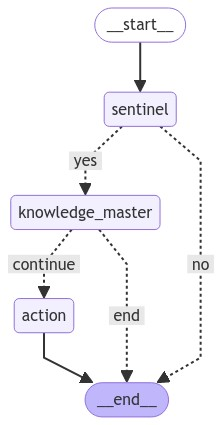

In [17]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print(f"Failed to display graph: {e}")

### Run our Graph

In [10]:
from langchain_core.messages import HumanMessage

message = "There are 6 people in my family. My wife doesn't eat meat and my youngest daughter is allergic to dairy."

inputs = {
    "messages": [HumanMessage(content=message)],
}

In [11]:
for output in app.with_config({"run_name": "Memory"}).stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'sentinel':
---
{'contains_information': 'yes'}

---

Output from node 'knowledge_master':
---
{'messages': [HumanMessage(content="There are 6 people in my family. My wife doesn't eat meat and my youngest daughter is allergic to dairy."), AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_9SM3uwRkgI35qHfILDj085dH', 'function': {'arguments': '{"knowledge": "Wife doesn\'t eat meat", "category": "Dislike", "action": "Create"}', 'name': 'Knowledge_Modifier'}, 'type': 'function'}, {'index': 1, 'id': 'call_7NOgPmq5tGMJ0ZIpH9xNHV77', 'function': {'arguments': '{"knowledge": "Youngest daughter is allergic to dairy", "category": "Allergy", "action": "Create"}', 'name': 'Knowledge_Modifier'}, 'type': 'function'}, {'index': 2, 'id': 'call_jacIo8osMqs2dmiU3eAIzepQ', 'function': {'arguments': '{"knowledge": "Family consists of 6 people", "category": "Attribute", "action": "Create"}', 'name': 'Knowledge_Modifier'}, 'type': 'function'}]}, response_metada